In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_normalised_jit_surface_area_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 0.01, 900]


times = np.linspace(20, 97, 78)

df = pd.read_csv('s11_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((78,5))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)
out_array[:,4] = np.divide(centred_moment_5,st_dev*st_dev*st_dev*st_dev*st_dev)

print(st_dev)

print(np.mean(org_values, axis=1))
print(centred_moment_3)

# print(centred_moments.shape)


[10.06376669  9.63391276  9.39582886  9.22513415  8.81750957  8.32179518
  7.83460912  7.85188512  7.54667311  7.48145039  7.11961375  6.99227252
  6.58293248  6.39531078  6.04660235  5.69082375  5.48378291  5.217612
  4.99342317  4.73428717  4.51302559  4.35228676  4.11629688  3.88418267
  3.55573832  3.50006786  3.41128641  3.25844672  3.04274136  2.94558568
  2.84015405  2.73372914  2.58696734  2.42038737  2.24910538  2.26218921
  2.120283    2.01078965  2.06121323  1.98128115  1.94598947  1.87480666
  1.81104942  1.72455791  1.69099823  1.61511609  1.5833193   1.43808901
  1.50727403  1.43788038  1.38573987  1.36747943  1.26581002  1.2495099
  1.2437343   1.25383412  1.22371361  1.18003178  1.12343224  1.17349904
  1.11860404  1.10021589  1.06719258  0.96709617  0.99673216  1.00965341
  1.00919522  0.93829633  0.97626841  0.90657322  0.86890736  0.81357237
  0.75714926  0.77142725  0.79693162  0.72143953  0.77942286  0.6609652 ]
[2.34  2.265 2.28  2.37  2.345 2.235 2.17  2.23  2.23

Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 5
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 1
noise_arr[2] = 1
noise_arr[3] = 1
noise_arr[4] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 8


Create uniform log prior

In [5]:

# Define the size of the list
size = 8
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100
prior_arr_lower[7] = 0
prior_arr_upper[7] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_41652/1618874681.py:31: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.6
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.5140195540966D+02   r2 =  0.1143827355337D-09


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1     597     0:15.6
2     1149    0:18.7
3     1731    0:20.5
20    9582    0:45.3
40    16470   1:04.6
60    22578   1:22.1
80    28737   1:39.7
100   35196   2:00.6
120   41721   2:18.9
140   47985   2:36.4
160   54660   2:55.3
180   60816   3:14.4
200   67233   3:32.5
220   73833   3:51.0
240   80433   4:09.9


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.9361401467999D+02   r2 =  0.4318322360538D-08
260   86832   4:30.0
280   93369   4:49.0
300   99933   5:07.5
320   106404   5:26.2
340   112716   5:45.7
360   118962   6:03.8
380   125550   6:22.9
400   132075   6:42.1
420   138579   7:01.8
440   144669   7:19.4
460   151143   7:41.1
480   157113   8:01.8
500   163500   8:23.3
520   169914   8:44.2
540   176145   9:09.1
560   182691   9:30.9
580   188910   9:53.6
600   195477  10:15.2
620   201936  10:36.6
640   208494  11:01.8
660   214713  11:22.3
680   220947  11:42.8
700   227187  12:03.2
720   233754  12:24.6
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.6873002059903D+02   r2 =  0.7600226903969D-12
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly

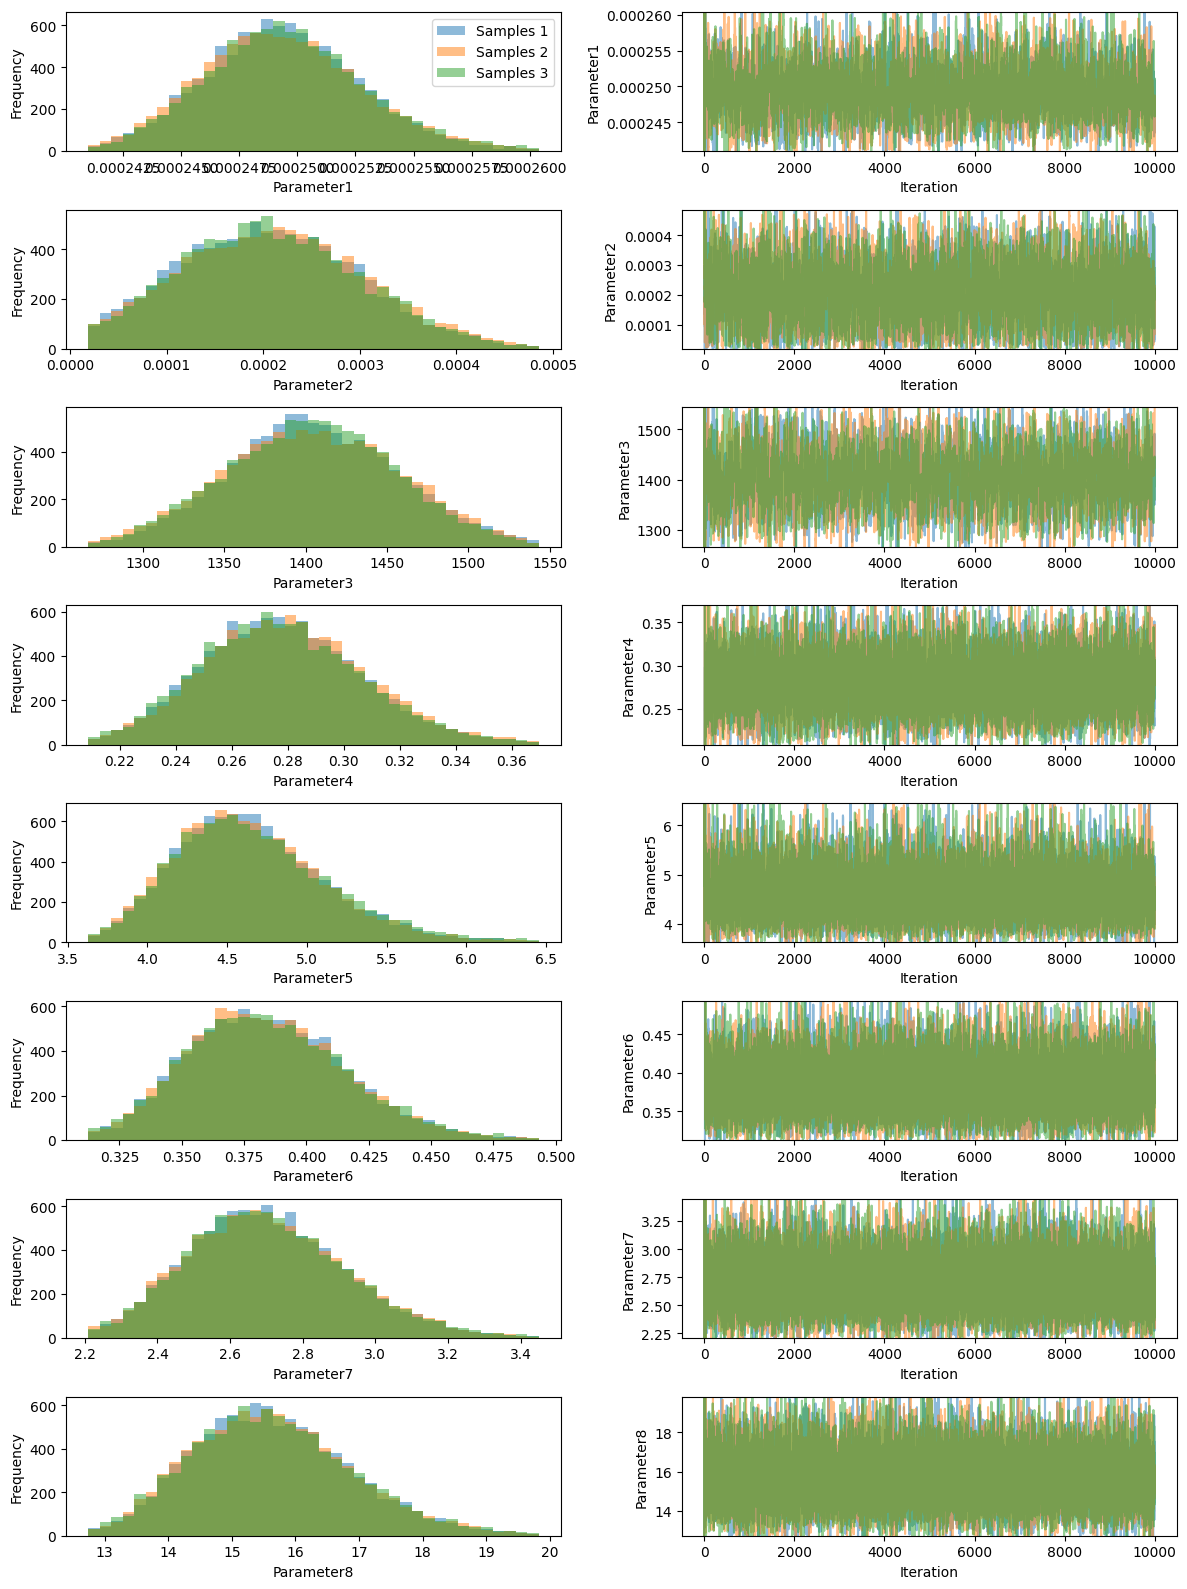

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# ITERS = 100
AllChains = chains[0,100:1000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 8)
[2.56526639e-04 3.46983515e-04 1.29308777e+03 2.72140525e-01
 5.63276386e+00 4.19501277e-01 3.15206870e+00 1.40958767e+01]
[[2.56526639e-04 3.46983515e-04 1.29308777e+03 ... 4.19501277e-01
  3.15206870e+00 1.40958767e+01]
 [2.55277613e-04 3.38005524e-04 1.30194021e+03 ... 3.31823541e-01
  3.14563029e+00 1.68857322e+01]
 [2.57271278e-04 3.91293005e-04 1.28722819e+03 ... 3.86936127e-01
  2.67712133e+00 1.49469641e+01]
 ...
 [2.48382781e-04 2.02248949e-04 1.43950104e+03 ... 3.45281356e-01
  2.55093245e+00 1.66956095e+01]
 [2.50949815e-04 2.18755514e-04 1.40552726e+03 ... 3.46762315e-01
  2.61077837e+00 1.47145251e+01]
 [2.47254282e-04 2.80565122e-04 1.44033297e+03 ... 3.33642902e-01
  2.58149380e+00 1.61151775e+01]]


In [9]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:1000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


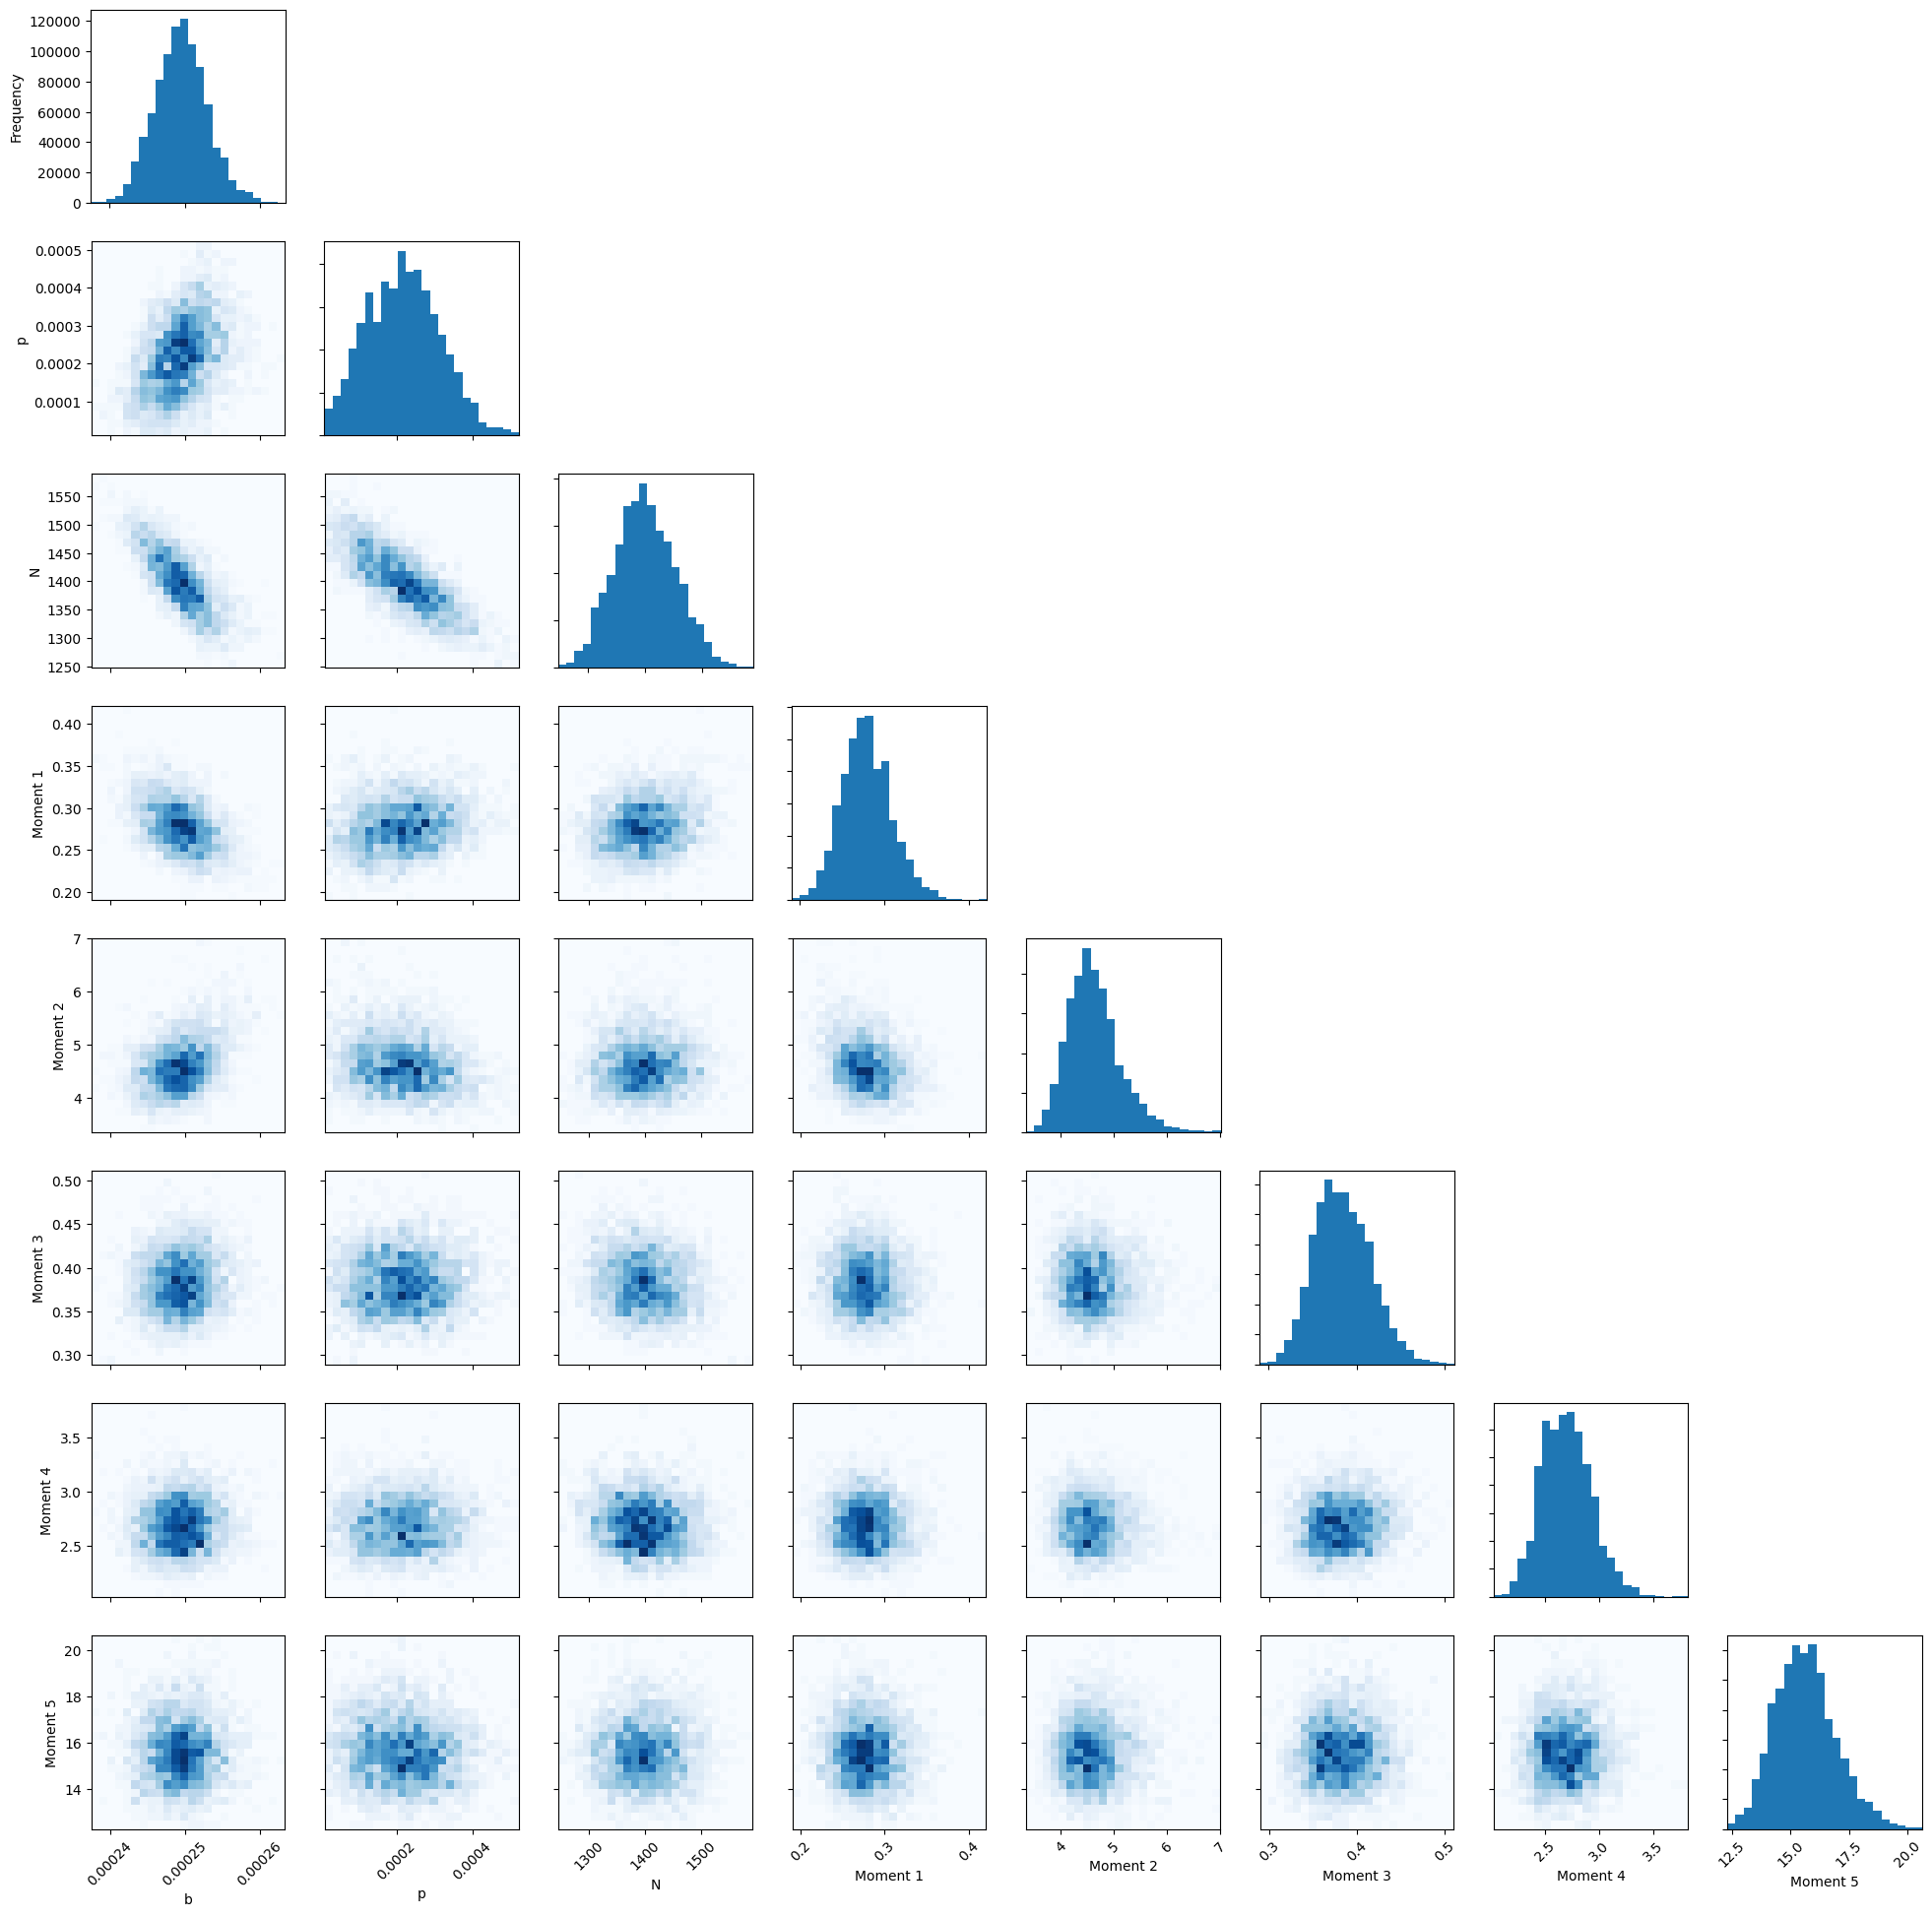

In [10]:


parameter_names = ["b", "p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b", "p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()

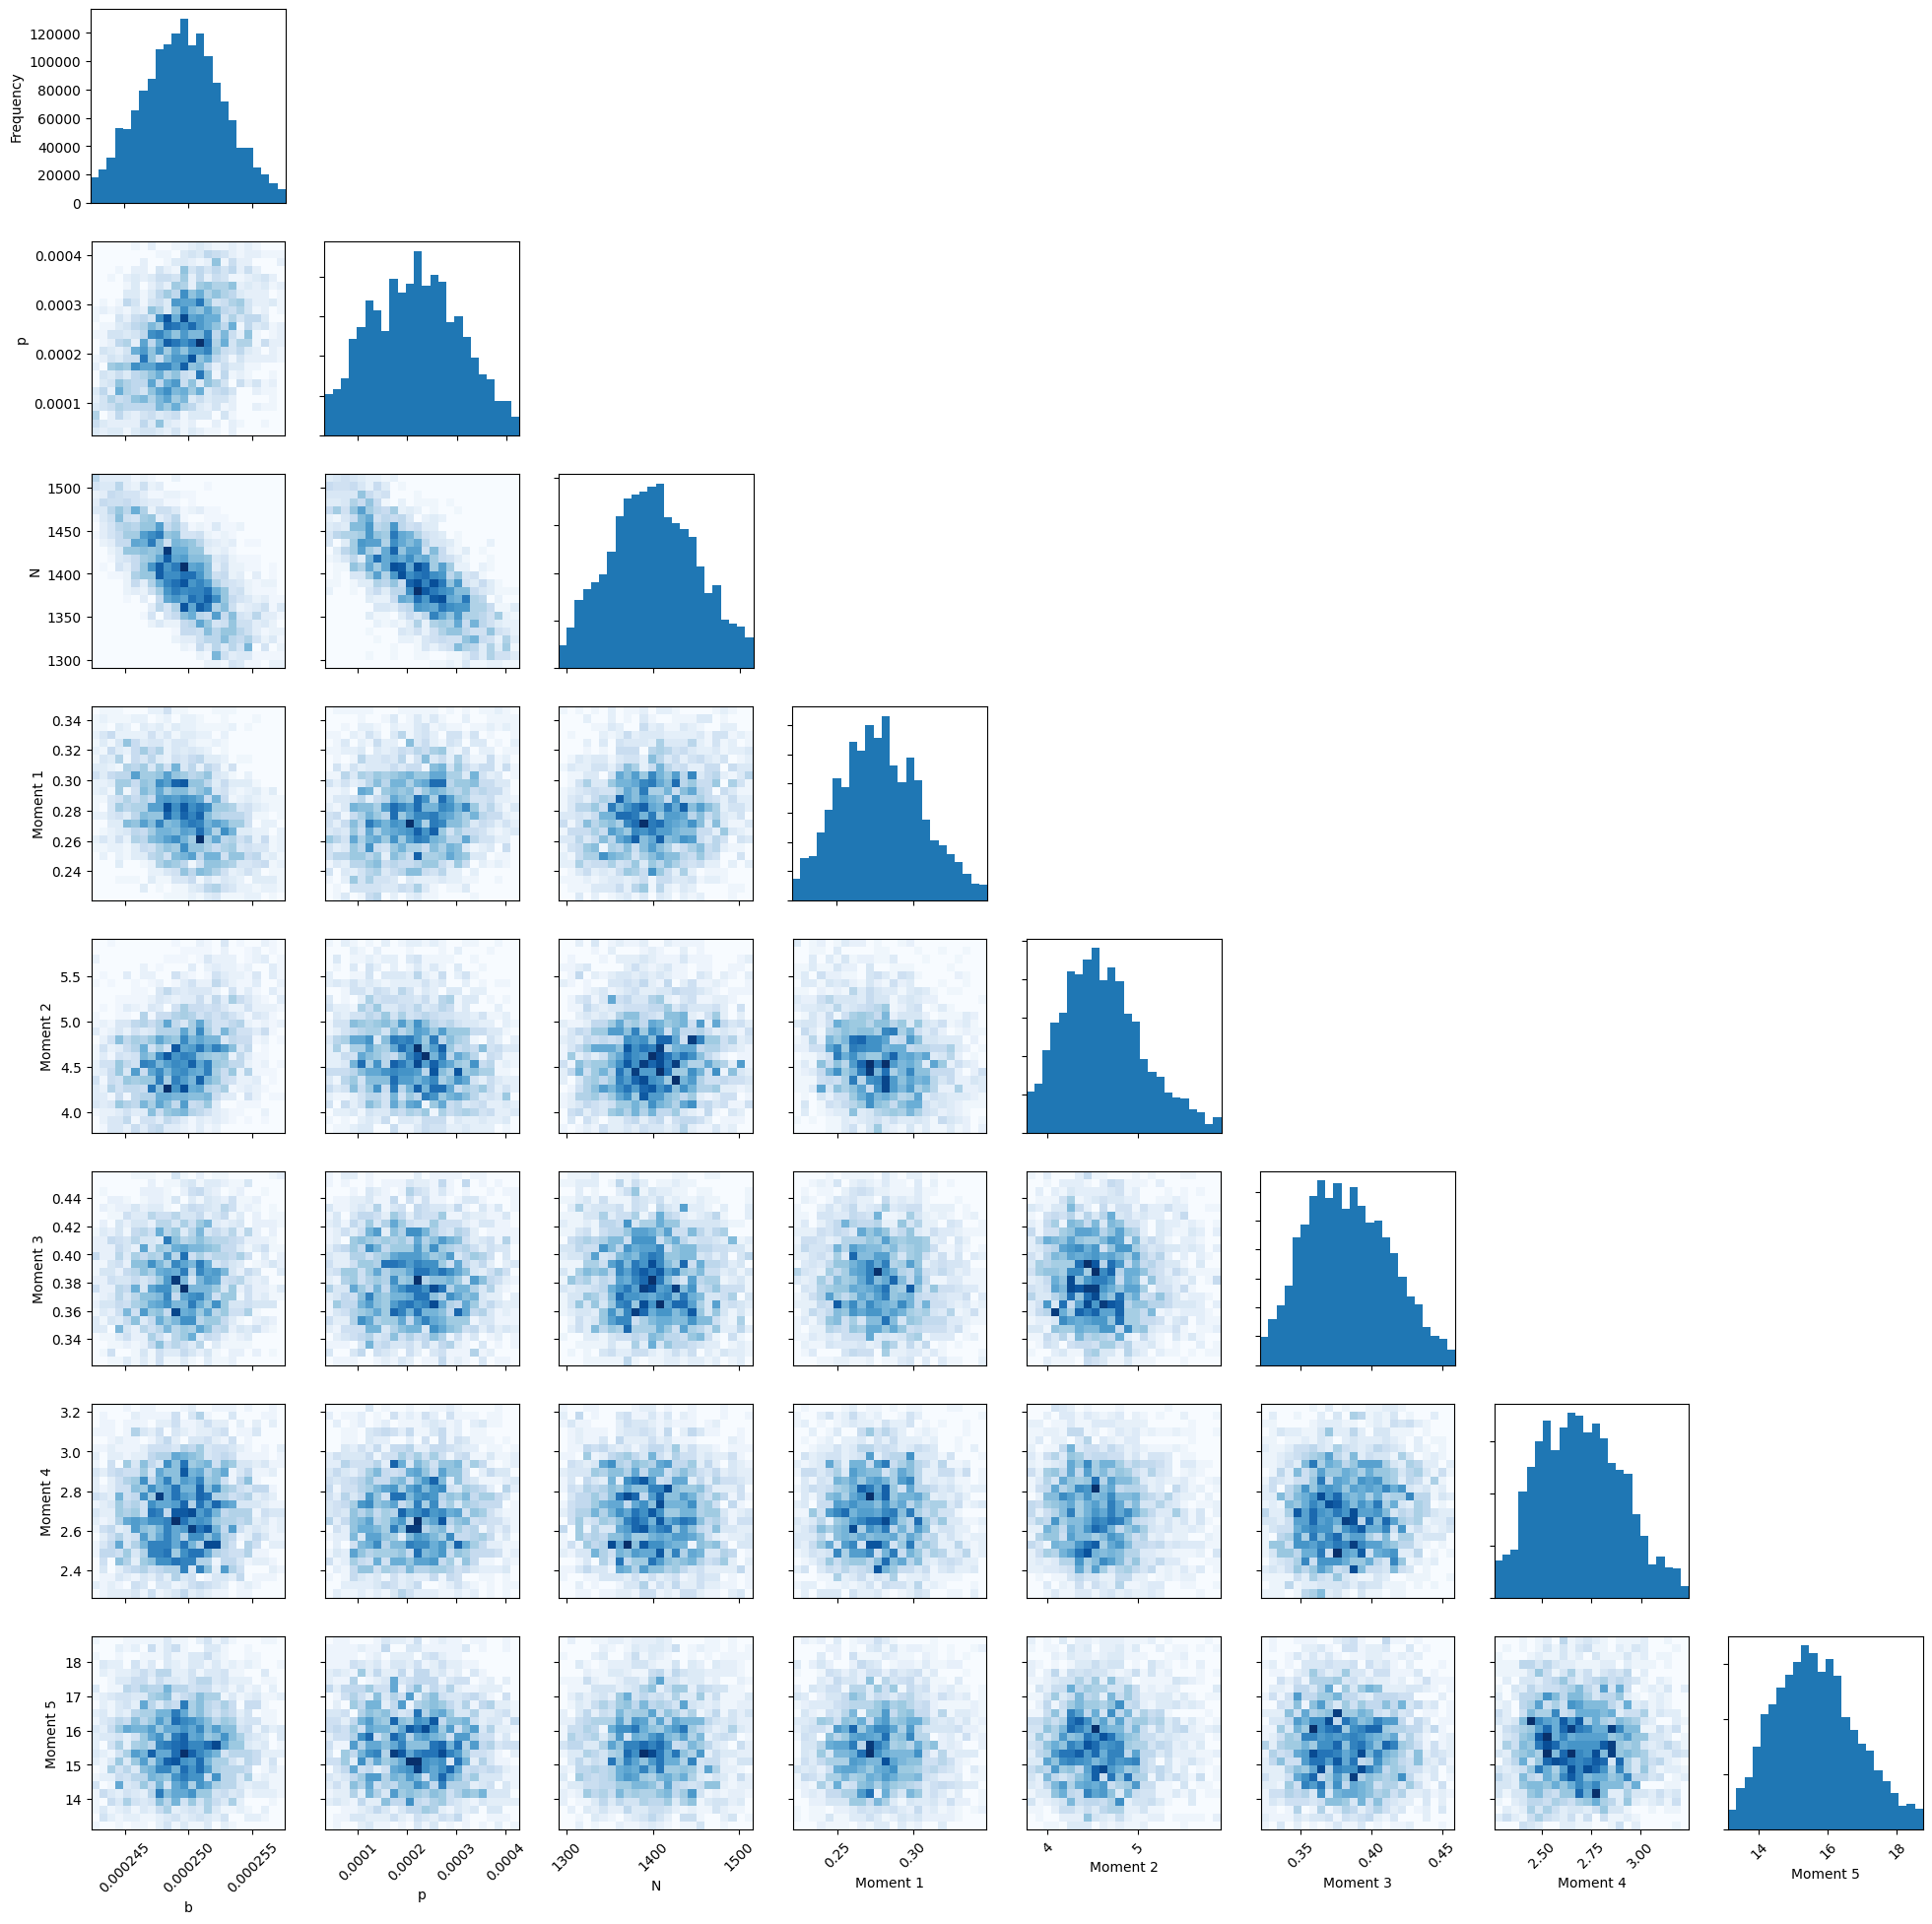

In [11]:
parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles=97)
                    
plt.show()

[2.56526639e-04 3.46983515e-04 1.29308777e+03 2.72140525e-01
 5.63276386e+00 4.19501277e-01 3.15206870e+00 1.40958767e+01]


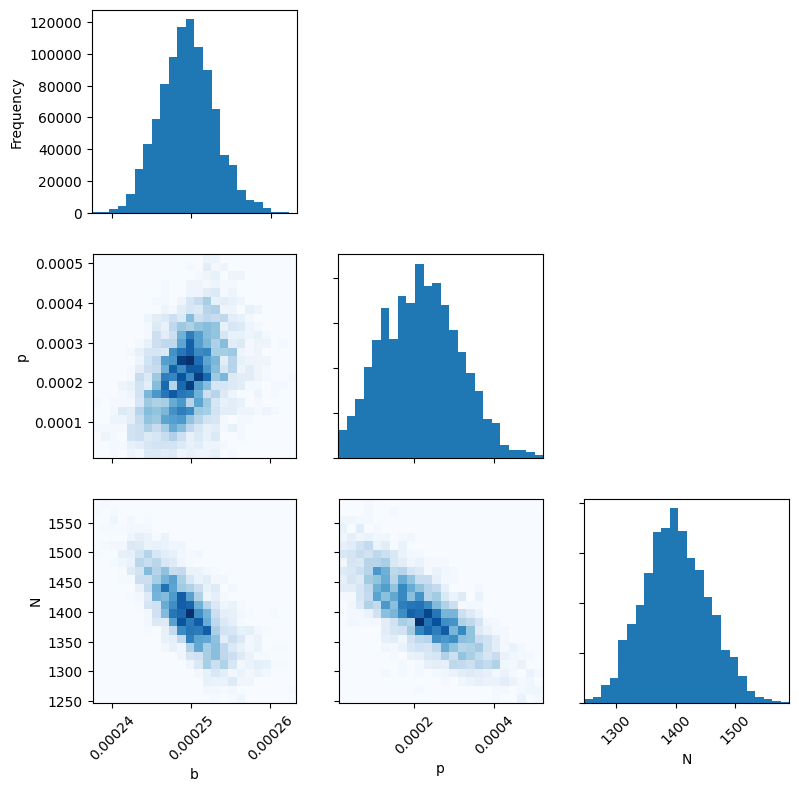

In [12]:
parameter_names = ["b","p","N"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,2]], heatmap=True, 
                    parameter_names=["b","p","N"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [13]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess      ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  -------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    1126.76  0.10
p         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    1289.93  0.12
N         1405.02  52.61   1301.56  1369.68  1404.89  1440.78  1508.14  1.00    983.58   0.09
Moment 1  0.28     0.03    0.23     0.26     0.28     0.30     0.34     1.00    2896.36  0.26
Moment 2  4.65     0.49    3.85     4.31     4.60     4.93     5.74     1.00    2818.54  0.25
Moment 3  0.38     0.03    0.33     0.36     0.38     0.40     0.45     1.00    4583.88  0.41
Moment 4  2.71     0.23    2.31     2.55     2.69     2.85     3.19     1.00    4733.65  0.43
Moment 5  15.63    1.28    13.38    14.73    15.55    16.41    18.42    1.00    4782.79  0.43

In [14]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [15]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  --------  --------------
b         0.000249  3.43e-06  0.000243  0.000247  0.000249  0.000251  0.000257  1       1.13e+03  0.102
p         0.000208  9.35e-05  4.08e-05  0.00014   0.000204  0.000272  0.0004    1       1.29e+03  0.116
N         1.41e+03  52.6      1.3e+03   1.37e+03  1.4e+03   1.44e+03  1.51e+03  1       984       0.0888
Moment 1  0.278     0.0293    0.225     0.258     0.277     0.297     0.34      1       2.9e+03   0.262
Moment 2  4.65      0.488     3.85      4.31      4.6       4.93      5.74      1       2.82e+03  0.255
Moment 3  0.384     0.0326    0.327     0.361     0.382     0.405     0.454     1       4.58e+03  0.414
Moment 4  2.71      0.226     2.31      2.55      2.69      2.85      3.19      1       4.73e+03  0.427
Moment 5  15.6

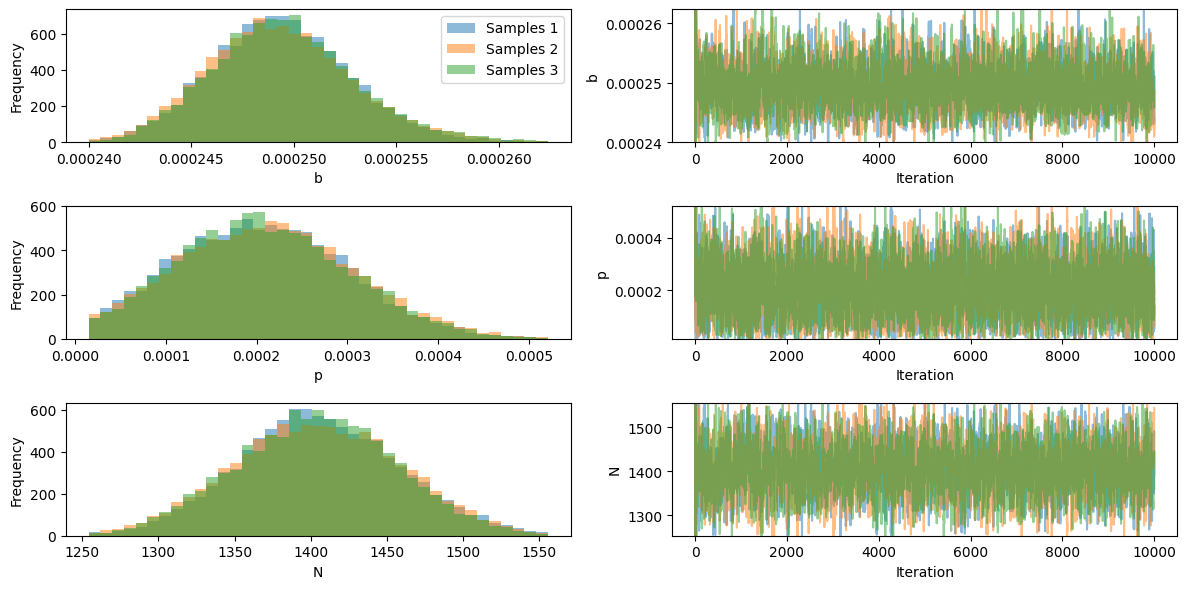

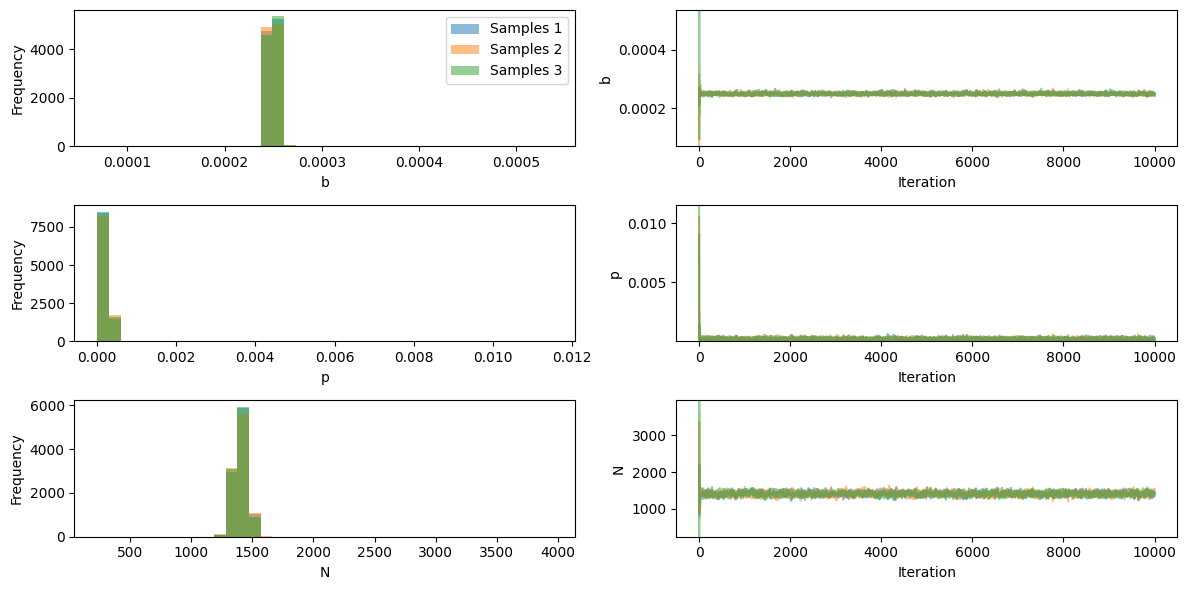

In [16]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()